<h1>Fraud Detection using autoencoder</h1>

In this notebook we will study fraud detection by analysing transaction's temporal and sequential dimensions.

<h2>1. Analyse the data:</h2>

* How many features do we have ?
* What the feature is used for ?
* How many NaN do we have ?
* Which feature is not essential for solving the problem ?

<h3>Train Identity dataset:</h3>

In [1]:
import numpy as np
import pandas as pd
import gc

datasetPath = ''

trainID = pd.read_csv(datasetPath+'train_identity.csv', encoding='utf-8')
trainID.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [2]:
((trainID.isna().sum()/trainID.shape[0])*100).sort_values(ascending=False)

id_24            96.708798
id_25            96.441868
id_07            96.425922
id_08            96.425922
id_21            96.423149
id_26            96.420375
id_23            96.416215
id_27            96.416215
id_22            96.416215
id_18            68.722137
id_03            54.016071
id_04            54.016071
id_33            49.187079
id_09            48.052110
id_10            48.052110
id_30            46.222432
id_32            46.207872
id_34            46.056034
id_14            44.503685
DeviceInfo       17.726179
id_13            11.726165
id_16            10.325654
id_06             5.108401
id_05             5.108401
id_20             3.447200
id_19             3.407681
id_17             3.372321
id_31             2.739318
DeviceType        2.373243
id_02             2.330257
id_28             2.256765
id_29             2.256765
id_11             2.256765
id_15             2.251912
id_35             2.251912
id_36             2.251912
id_37             2.251912
i

Some columns have 96% NaN values !

<h3>Train Transaction dataset:</h3>

In [3]:
trainTR = pd.read_csv(datasetPath+'train_transaction.csv', encoding='utf-8')
trainTR.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
((trainTR.isna().sum()/trainTR.shape[0])*100).sort_values(ascending=False)

dist2            93.628374
D7               93.409930
D13              89.509263
D14              89.469469
D12              89.041047
                   ...    
C1                0.000000
C2                0.000000
C14               0.000000
isFraud           0.000000
TransactionID     0.000000
Length: 394, dtype: float64

In [5]:
(trainTR['TransactionDT'].max() - trainTR['TransactionDT'].min())/(60*60*24*30)

6.066640046296296

The data is made from the last 6 months

In [6]:
tab = 'V202'
print("Percent of NaN:", (trainTR[tab].isna().sum()/trainTR[tab].shape[0])*100)
print(trainTR[tab][trainTR[tab].notna()])
del tab

Percent of NaN: 76.35536966166559
4           0.000000
8           0.000000
10        166.215393
11          0.000000
16          0.000000
             ...    
590521    451.078796
590526      0.000000
590529      0.000000
590531      0.000000
590534      0.000000
Name: V202, Length: 139631, dtype: float64


Quite a strange data, all the VS data are (according to vesta): "engineered rich features, including ranking, counting, and other entity relations."

In [7]:
print(trainTR['isFraud'].value_counts(normalize=False))
print(trainTR['isFraud'].value_counts(normalize=True))

0    569877
1     20663
Name: isFraud, dtype: int64
0    0.96501
1    0.03499
Name: isFraud, dtype: float64


Only 3.5% (20663) are fraudulous transactions

**What we know so far:**

Not useful:
* TransactionID
* TransactionDT
* isFraud

Transaction Table - Categorical Features:
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Identity Table - Categorical Features:
* Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38

<h2>2. Preprocess the data:</h2>

* Left join the dataframes
* Replace columns with more than 80% NaN with binary data
* Convert the NaN
* Separate fraudulent transactions from normal
* Encode categorical features
* Normalize input vectors
* Make a validation set from 10% of normal transactions

In [8]:
to_replace = []

def make_hour_feature(f):
    #Creates an hour of the day feature, encoded as 0-23.  
    hours = f / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

def preprocessData(dataTR, dataID, training=True):
    global to_replace
    train = pd.merge(dataTR, dataID, on='TransactionID', how='left')
    del dataTR; del dataID
    
    train['hour'] = make_hour_feature(train['TransactionDT'])

    cat_features = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'
                    , 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo'
                    , 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24'
                    , 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37'
                    , 'id_38']

    exclude = ['TransactionID', 'TransactionDT', 'isFraud']

    if(training):
        # binary categorical if more than 80% NAs (only numerical)
        col_na = train.isna().sum()
        to_replace = col_na[(col_na / train.shape[0]) > 0.8].index
        to_replace = [f for f in to_replace if f not in cat_features]
        print(to_replace)
        
    num_features = [f for f in train.columns if (f not in to_replace) & (f not in cat_features) & (f not in exclude)]

    train[cat_features].astype(str)
    train[to_replace].astype(str)
    train[num_features].astype(np.float)
    
    # fill numeric NAs with median
    for tab in num_features:
        train.loc[train[tab].isnull(), tab] = train[tab].median()

    # fill categorical NAs with "m" for missing and "nm" for not missing
    for tab in cat_features:
        train.loc[train[tab].isnull(), tab] = "m"
    for tab in to_replace:
        train.loc[train[tab].notnull(), tab] = "nm"
        train.loc[train[tab].isnull(), tab] = "m"
    
    if(training): train.drop(columns=['TransactionID', 'TransactionDT'], axis=1, inplace=True)
    else: train.drop(columns=['TransactionDT'], axis=1, inplace=True)
    #train.drop(columns=to_replace, axis=1, inplace=True)
        
    cat_features = train.select_dtypes(exclude=np.number).columns
    
    return train, num_features, cat_features

In [9]:
train, num_features, cat_features = preprocessData(trainTR, trainID)
del trainTR; del trainID

['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10']


In [10]:
#Separate fraud from normal transactions

fraudData = train.loc[train['isFraud'] == 1, :]
train = train.loc[train['isFraud'] == 0, :]
print(len(fraudData))
print(len(train))
print("train NaN:", train.isna().sum().sum())
print("fraud NaN:", fraudData.isna().sum().sum())

20663
569877
train NaN: 0
fraud NaN: 0


In [11]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train[num_features+list(cat_features)], train['isFraud'], test_size=0.1)
fraudVal = fraudData['isFraud']
fraudData = fraudData[num_features+list(cat_features)]
print(len(train_X), 'train examples')
print(len(val_X), 'validation examples')

del train

512889 train examples
56988 validation examples


In [12]:
from category_encoders.binary import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def makeTransformer():
    # Numerical columns will be scaled by StandardScaler
    scaler = StandardScaler()

    # Categorical values will be encoded using Binary Encoder
    bie = BinaryEncoder()

    column_trans = ColumnTransformer(
        [('scaler',scaler, num_features),
        ('bie', bie, cat_features)], remainder='passthrough', n_jobs=-1)
    
    return column_trans

column_trans = makeTransformer()

train_X_transformed = column_trans.fit_transform(train_X)
val_X_transformed = column_trans.transform(val_X)

del num_features; del cat_features
del val_X; del train_X
gc.collect()

print(train_X_transformed.shape, val_X_transformed.shape)

(512889, 678) (56988, 678)


<h2>3. Create and train the model</h2>

The fun begins here (in my opinion), we will create an autoencoder and compute the mean squared error of the reconstructed data.

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

def makeModel():
    inputs = layers.Input(train_X_transformed.shape[1])
    x = layers.Dense(544, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(inputs)
    x = layers.Dense(352, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    x = layers.Dense(160, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    x = layers.Dense(96, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    x = layers.Dense(160, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    x = layers.Dense(352, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    x = layers.Dense(544, activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    output = layers.Dense(train_X_transformed.shape[1], activation="relu", activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)

    model = Model(inputs, output, name="Autoencoder")
    return model

model = makeModel()
model.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 678)]             0         
_________________________________________________________________
dense (Dense)                (None, 544)               369376    
_________________________________________________________________
dense_1 (Dense)              (None, 352)               191840    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               56480     
_________________________________________________________________
dense_3 (Dense)              (None, 96)                15456     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               15520     
_________________________________________________________________
dense_5 (Dense)              (None, 352)               

In [14]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.MeanSquaredLogarithmicError())

history = model.fit(
    x=train_X_transformed,
    y=train_X_transformed,
    validation_data=(val_X_transformed, val_X_transformed),
    batch_size=1024,
    epochs=50)

Epoch 1/50
501/501 [==============================] - 20s 33ms/step - loss: 0.0267 - val_loss: 0.0180
Epoch 2/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 3/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 4/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 5/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 6/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 7/50
501/501 [==============================] - 16s 32ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 8/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 9/50
501/501 [==============================] - 16s 31ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 10/50
501/501 [==============================] - 16s 31ms/step - loss: 0.009

In [15]:
model.save_weights("autoencoder_weights.h5")

In [16]:
model.load_weights("autoencoder_weights.h5")

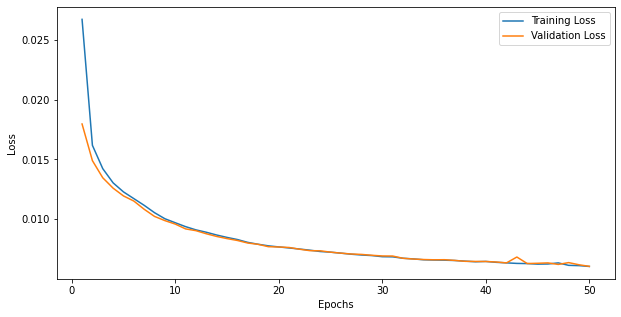

In [17]:
import matplotlib.pyplot as plt

def plotHistory():
    lossV = history.history['loss']
    epochs = range(1, len(lossV)+1)

    val_lossV = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lossV, label='Training Loss')
    plt.plot(epochs, val_lossV, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
plotHistory()

<h2>4. Determine the threshold for fraud data</h2>

To finish we need to determine the threshold (for fraud data) of the reconstruction error (mean squared error).

In order to do that we will optimize the sum of true positive percentage and false positive percentage (TP(%) and FP(%)).

In [18]:
from sklearn.metrics import accuracy_score

def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    print(reconstruction_errors)
    threshold = np.mean(reconstruction_errors.numpy())
    return threshold

gc.collect()

threshold = find_threshold(model, val_X_transformed)
print(f"Threshold: {threshold}")

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    predictions = tf.keras.losses.msle(predictions, x_test_scaled)
    # 1 = anomaly, 0 = normal
    anomaly_mask = pd.Series(predictions) > threshold
    predictions = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    return predictions

gc.collect()

fraudData_transformed = column_trans.transform(fraudData)
TP = 0; FP = 0; tmp = 0; maxi = 0
for i in range(20):
    predictions = get_predictions(model, fraudData_transformed, threshold*(1.5-(i*0.05)))
    FP = accuracy_score(predictions, fraudVal)

    predictions = get_predictions(model, val_X_transformed, threshold*(1.5-(i*0.05)))
    TP = accuracy_score(predictions, val_y)
    print('\nfraud acc:', FP)
    print('val acc:', TP)
    print('SUM:', TP+FP)
    if(tmp < TP+FP):
        maxi = i
        tmp = TP+FP

threshold = threshold*(1.5-(maxi*0.05))

tf.Tensor([0.00087458 0.0224313  0.00010869 ... 0.00034977 0.00025197 0.00088033], shape=(56988,), dtype=float64)
Threshold: 0.003832343673472487

fraud acc: 0.5897013986352417
val acc: 0.8260335509230013
SUM: 1.4157349495582432

fraud acc: 0.5991385568407298
val acc: 0.8185056503123465
SUM: 1.4176442071530762

fraud acc: 0.6070754488699608
val acc: 0.8111005825787885
SUM: 1.4181760314487493

fraud acc: 0.6145767797512461
val acc: 0.8030638029058749
SUM: 1.417640582657121

fraud acc: 0.6219813192663215
val acc: 0.793816242015863
SUM: 1.4157975612821845

fraud acc: 0.630305376760393
val acc: 0.7841826349406893
SUM: 1.4144880117010823

fraud acc: 0.6407104486279824
val acc: 0.7744612900961606
SUM: 1.4151717387241431

fraud acc: 0.649808837051735
val acc: 0.7632133080648558
SUM: 1.4130221451165907

fraud acc: 0.659149203891013
val acc: 0.7524040148803257
SUM: 1.4115532187713387

fraud acc: 0.668586362096501
val acc: 0.7403663929248263
SUM: 1.4089527550213274

fraud acc: 0.6791850166965107

<h2>5. Test the model !</h2>

To conclude we will test the model on fraud data and on the test dataset

In [19]:
predictions = get_predictions(model, fraudData_transformed, threshold)
FP = accuracy_score(predictions, fraudVal)

predictions = get_predictions(model, val_X_transformed, threshold)
TP = accuracy_score(predictions, val_y)

print('threshold:', threshold)
print('\nfraud acc:', FP)
print('val acc:', TP)
print('\nSUM:', TP+FP)

threshold: 0.005365281142861482

fraud acc: 0.6070754488699608
val acc: 0.8111005825787885

SUM: 1.4181760314487493


And now we are able to make predictions on transactions !

Though, 60% of frauds will be detected and 19% of normal transaction will be misclassified which is not enough, in order to improve it we'll have to improve the feature engineering part, or change the model.